# SplitGLORY：在隐语中使用基于全局图拆分的推荐算法

2023年发表在RecSys上新闻推荐的论文 **《Going Beyond Local: Global Graph-Enhanced Personalized News Recommendations》**，提出了GLORY模型。通过利用所有用户点击累计频次构成的全局点击图中使用图神经网络提取隐含在不同的新闻邻居之中的潜在高阶特征增强新闻推荐的效果，但是在隐私保护的多联邦场景下，难以利用全局图进行协同的新闻推荐，因此针对这种场景下，设计了基于全局图共享的联邦拆分学习。本文重点介绍如何在隐语中使用拆分GLORY的算法。

## GLORY模型

GLORY的全局图是通过所有用户来构建的，使用GGNN网络捕捉用户行为序列中的信息，整体结构如下:

![整体结构](graph/1.png)
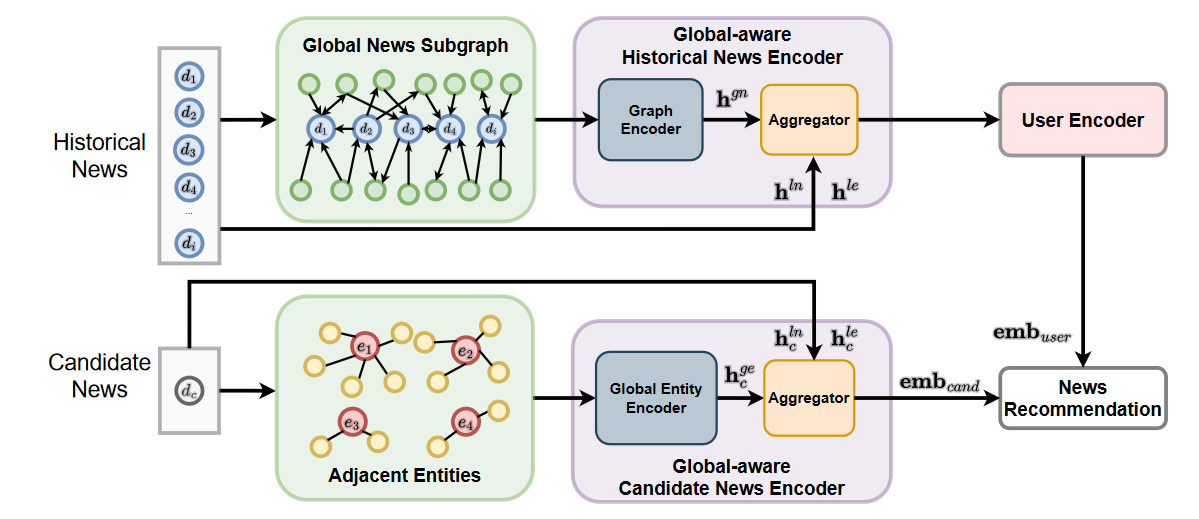

但是上述的模型结构在**多联邦推荐场景**下面临着很多问题，比如说：
* 本地用户的存储和共享的通信开销大，难以构建和存储基于本地的用户全局点击图

* 新闻的全局点击图的表征学习主要依赖的是GGNN网络，计算开销大，难以在本地用户场景下完全学习到用户的表征



![问题](graph/2.png)
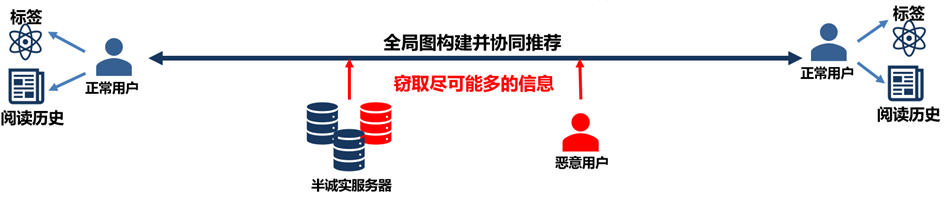

首先需要对隐私保护的问题进行定义，在当前的推荐系统中，数据持有者（客户端）和服务器通常被认为是诚实的，但在某些场景下，他们可能会因好奇而尝试推断尽可能多的隐私信息。所谓“诚实但好奇”（半诚实）模型，意味着客户端和服务器虽然严格遵循协议，不进行恶意行为，但他们可能会利用协议中产生的所有中间计算结果，试图推测更多的用户数据，尤其是敏感的标签（label）和点击历史（history）。在这种情况下，服务器虽然不与任何数据持有者串通，但却可能通过对交互数据的深度分析，窥探到用户的隐私信息，进而影响系统的安全性和隐私性。

![拆分学习](graph/3.png)
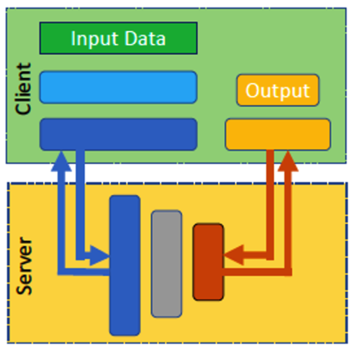

因此，我们将拆分学习方法应用到这种全局图的隐私推荐场景中，利用拆分学习的U-shape方法，在服务器端进行全局图的计算，通过把高负荷的存储量和计算量迁移到服务器端，在所有用户都不知道其他用户隐私数据的场景下，进行新闻推荐。

## 数据集介绍

包含约16万篇新闻文章、100万匿名用户产生的1500万次新闻曝光记录及2400万次点击行为。数据采集自Microsoft News用户6周的匿名行为日志，覆盖新闻标题、摘要、正文等丰富文本信息。

数据划分：
分为训练集、验证集和测试集，每个子集包含以下4类文件：
* news.tsv：新闻元数据（标题、摘要、类别、实体等）
* behaviors.tsv：用户曝光日志与点击历史
* entity_embedding.vec：新闻标题/摘要中实体的知识图谱嵌入
* relation_embedding.vec：实体间关系的嵌入表示

下载链接：https://msnews.github.io/

## 处理数据集

在data文件下有三个数据处理的文件，首先利用data_preprocess.py预先将用户行为数据分布式分片、提取新闻特征构建结构化数据、根据浏览记录生成新闻与实体的关联图谱，最终输出包含语义关系和图结构的标准化持久化数据。再利用dataset.py对数据进行封装成dataset类，最后通过下面的data_load.py加载数据进行后续的训练操作

In [ ]:
import logging
from pathlib import Path

import numpy as np
import torch
from torch.utils.data import DataLoader
from torch_geometric.utils import to_undirected
from tqdm import tqdm
import pickle

from dataload.dataset import *  # 导入自定义数据集模块


def load_data(cfg, mode='train', model=None, local_rank=0):
    """
    加载训练、验证或测试数据。

    :param cfg: 配置文件
    :param mode: 数据模式，可选 'train', 'val', 'test'
    :param model: 模型对象，只有在验证或测试时需要
    :param local_rank: 当前进程的GPU编号
    :return: 返回DataLoader
    """

    # 根据模式选择数据路径
    data_dir = {"train": cfg.dataset.train_dir, "val": cfg.dataset.val_dir, "test": cfg.dataset.test_dir}

    # ------------- 加载新闻数据 -------------
    # 载入新闻索引和新闻内容
    news_index = pickle.load(open(Path(data_dir[mode]) / "news_dict.bin", "rb"))
    news_input = pickle.load(open(Path(data_dir[mode]) / "nltk_token_news.bin", "rb"))

    # ------------- 加载行为数据 -------------
    if mode == 'train':
        # 训练模式下，加载行为数据
        target_file = Path(data_dir[mode]) / f"behaviors_np{cfg.npratio}_{local_rank}.tsv"

        if cfg.model.use_graph:
            # 如果使用图结构模型，加载新闻图数据
            news_graph = torch.load(Path(data_dir[mode]) / "nltk_news_graph.pt")

            # 如果是无向图，转换成无向图
            if cfg.model.directed is False:
                news_graph.edge_index, news_graph.edge_attr = to_undirected(news_graph.edge_index, news_graph.edge_attr)
            print(f"[{mode}] News Graph Info: {news_graph}")

            # 加载新闻邻居字典
            news_neighbors_dict = pickle.load(open(Path(data_dir[mode]) / "news_neighbor_dict.bin", "rb"))

            # 如果模型使用实体图，还需要加载实体邻居数据
            if cfg.model.use_entity:
                entity_neighbors = pickle.load(open(Path(data_dir[mode]) / "entity_neighbor_dict.bin", "rb"))
                total_length = sum(len(lst) for lst in entity_neighbors.values())
                print(f"[{mode}] entity_neighbor list Length: {total_length}")
            else:
                entity_neighbors = None

            # 创建训练图数据集
            dataset = TrainGraphDataset(
                filename=target_file,
                news_index=news_index,
                news_input=news_input,
                local_rank=local_rank,
                cfg=cfg,
                neighbor_dict=news_neighbors_dict,
                news_graph=news_graph,
                entity_neighbors=entity_neighbors
            )
            dataloader = DataLoader(dataset, batch_size=None)  # 创建DataLoader

        else:
            # 不使用图结构模型时，直接加载普通的训练数据集
            dataset = TrainDataset(
                filename=target_file,
                news_index=news_index,
                news_input=news_input,
                local_rank=local_rank,
                cfg=cfg,
            )

            # 创建DataLoader，按GPU数进行批量划分
            dataloader = DataLoader(dataset,
                                    batch_size=int(cfg.batch_size / cfg.gpu_num),
                                    pin_memory=True)
        return dataloader
    elif mode in ['val', 'test']:
        # 转换新闻数据为嵌入
        news_dataset = NewsDataset(news_input)
        news_dataloader = DataLoader(news_dataset,
                                     batch_size=int(cfg.batch_size * cfg.gpu_num),
                                     num_workers=cfg.num_workers)

        stacked_news = []
        with torch.no_grad():
            # 在验证和测试模式下，计算新闻的嵌入表示
            for news_batch in tqdm(news_dataloader, desc=f"[{local_rank}] Processing validation News Embedding"):
                # 如果使用图模型，计算嵌入
                if cfg.model.use_graph:
                    batch_emb = model.module.client.local_news_encoder(news_batch.long().unsqueeze(0).to(local_rank)).squeeze(
                        0).detach()
                else:
                    batch_emb = model.module.client.local_news_encoder(news_batch.long().unsqueeze(0).to(local_rank)).squeeze(
                        0).detach()
                stacked_news.append(batch_emb)

        # 拼接所有新闻的嵌入表示
        news_emb = torch.cat(stacked_news, dim=0).cpu().numpy()

        if cfg.model.use_graph:
            # 如果使用图结构模型，加载图数据
            news_graph = torch.load(Path(data_dir[mode]) / "nltk_news_graph.pt")
            news_neighbors_dict = pickle.load(open(Path(data_dir[mode]) / "news_neighbor_dict.bin", "rb"))

            # 如果是无向图，转换成无向图
            if cfg.model.directed is False:
                news_graph.edge_index, news_graph.edge_attr = to_undirected(news_graph.edge_index, news_graph.edge_attr)
            print(f"[{mode}] News Graph Info: {news_graph}")

            # 如果使用实体图，加载实体邻居数据
            if cfg.model.use_entity:
                # entity_graph = torch.load(Path(data_dir[mode]) / "entity_graph.pt")
                entity_neighbors = pickle.load(open(Path(data_dir[mode]) / "entity_neighbor_dict.bin", "rb"))
                total_length = sum(len(lst) for lst in entity_neighbors.values())
                print(f"[{mode}] entity_neighbor list Length: {total_length}")
            else:
                entity_neighbors = None

            # 验证模式下，使用图数据集
            if mode == 'val':
                dataset = ValidGraphDataset(
                    filename=Path(data_dir[mode]) / f"behaviors_np{cfg.npratio}_{local_rank}.tsv",
                    news_index=news_index,
                    news_input=news_emb,
                    local_rank=local_rank,
                    cfg=cfg,
                    neighbor_dict=news_neighbors_dict,
                    news_graph=news_graph,
                    news_entity=news_input[:, -8:-3],
                    entity_neighbors=entity_neighbors
                )

            # 创建DataLoader
            dataloader = DataLoader(dataset, batch_size=None)

        else:
            # 不使用图结构时，使用普通的验证数据集
            if mode == 'val':
                dataset = ValidDataset(
                    filename=Path(data_dir[mode]) / f"behaviors_{local_rank}.tsv",
                    news_index=news_index,
                    news_emb=news_emb,
                    local_rank=local_rank,
                    cfg=cfg,
                )
            else:
                dataset = ValidDataset(
                    filename=Path(data_dir[mode]) / f"behaviors.tsv",
                    news_index=news_index,
                    news_emb=news_emb,
                    local_rank=local_rank,
                    cfg=cfg,
                )

            # 创建DataLoader
            dataloader = DataLoader(dataset,
                                    batch_size=1,
                                    collate_fn=lambda b: collate_fn(b, local_rank))
        return dataloader


def collate_fn(tuple_list, local_rank):
    """
    定义如何将批次中的样本合并为一个batch。

    :param tuple_list: 一个包含样本的列表，每个样本是一个元组
    :param local_rank: 当前进程的GPU编号
    :return: 合并后的batch数据
    """
    # 分别提取clicked_news、clicked_mask、candidate_news等数据
    clicked_news = [x[0] for x in tuple_list]
    clicked_mask = [x[1] for x in tuple_list]
    candidate_news = [x[2] for x in tuple_list]
    clicked_index = [x[3] for x in tuple_list]
    candidate_index = [x[4] for x in tuple_list]

    # 如果样本包含标签，则一并返回
    if len(tuple_list[0]) == 6:
        labels = [x[5] for x in tuple_list]
        return clicked_news, clicked_mask, candidate_news, clicked_index, candidate_index, labels
    else:
        return clicked_news, clicked_mask, candidate_news, clicked_index, candidate_index


## 定义模型结构

将模型拆分成GLORYServer和GLORYClient两个部分，最后通过GLORYSplit将完整的流程串起来，实现的是拆分学习中的U-shape策略,通过这个GLORYSplit模型实现了基于全局点击图的拆分学习的推荐，保护了用户的隐私数据。

### 1. GLORYClient
客户端侧部署轻量化模型，基于本地新闻数据执行细粒度语义特征提取，同时接收服务端下发的全局图向量，通过门控注意力网络将其与本地特征融合，实现隐私保护的混合表征计算。此过程严格遵循数据不动模型动原则，原始新闻内容始终驻留本地设备。

### 2.GLORYServer
作为全局知识中枢，GLORYServer通过联邦聚合机制构建并持续优化全局点击图（Global Click Graph），利用图卷积网络（GCN）学习新闻节点的联合嵌入表征。完成训练后，通过分层加密通道将新闻语义向量安全分发至各客户端，为本地模型提供跨用户兴趣模式的先验知识支撑。

### 3. GLORYSplit
GLORYSplit作为协作引擎，驱动客户端与服务端的双向交互：首先将GLORYClient生成的新闻向量安全上传至GLORYServer，用于全局点击图的迭代更新；随后，服务端将融合群体行为模式的增强版新闻向量回传至客户端。最终在客户端侧，通过自适应加权模块（如动态调整本地/全局特征权重系数）实现新闻节点向量的联合优化，完成隐私与效能的平衡。

In [ ]:
class GLORYServer(nn.Module):
    '''
    服务器只计算global gnn
    '''
    def __init__(self, cfg, glove_emb=None,):
        super().__init__()
        self.cfg = cfg
        self.news_dim = cfg.model.head_num * cfg.model.head_dim  # 新闻的维度

        # GCN（图卷积网络）
        self.global_news_encoder = Sequential('x, index', [
            (GatedGraphConv(self.news_dim, num_layers=3, aggr='add'), 'x, index -> x'),  # 采用 GatedGraphConv 进行图卷积
        ])

    def forward(self, x_encoded, edge_index, mapping_idx):
        # 服务器端计算图卷积特征
        graph_emb = self.global_news_encoder(x_encoded, edge_index)
        # clicked_graph_emb = graph_emb[mapping_idx, :]

        return graph_emb


class GLORYClient(nn.Module):
    '''
    客户端负责本地新闻的语义计算和后续全局图向量传入的计算
    '''
    def __init__(self, cfg, entity_emb, glove_emb=None, ):
        super().__init__()
        self.cfg = cfg
        self.news_dim = cfg.model.head_num * cfg.model.head_dim  # 新闻的维度
        self.local_news_encoder = NewsEncoder(cfg, glove_emb)
        self.click_encoder = ClickEncoder(cfg)
        self.user_encoder = UserEncoder(cfg)
        self.candidate_encoder = CandidateEncoder(cfg)
        self.click_predictor = DotProduct()
        self.use_entity = cfg.model.use_entity
        self.entity_dim = cfg.model.entity_emb_dim  # 实体的维度
        self.loss_fn = NCELoss()
        # 实体编码器
        if self.use_entity:
            pretrain = torch.from_numpy(entity_emb).float()  # 使用预训练的实体嵌入
            self.entity_embedding_layer = nn.Embedding.from_pretrained(pretrain, freeze=False, padding_idx=0)  # 实体嵌入层

            # 局部实体编码器
            self.local_entity_encoder = Sequential('x, mask', [
                (self.entity_embedding_layer, 'x -> x'),
                (EntityEncoder(cfg), 'x, mask -> x'),  # 使用 EntityEncoder 进行实体编码
            ])
            self.global_entity_encoder = Sequential('x, mask', [
                (self.entity_embedding_layer, 'x -> x'),
                (GlobalEntityEncoder(cfg), 'x, mask -> x'),  # 使用 GlobalEntityEncoder 进行全局实体编码
            ])


    def forward(self, subgraph, mapping_idx, candidate_news, candidate_entity, entity_mask, label=None):
        # ----------------- 计算客户端的 x_encoded -----------------
        x_encoded, mask, mapping_idx, batch_size, num_clicked, clicked_entity = self.process_news(subgraph, mapping_idx,
                                                                                                  candidate_news,
                                                                                                  candidate_entity,
                                                                                                  entity_mask)

        # 服务器端返回 clicked_graph_emb
        # 假设服务器端已经计算好了 clicked_graph_emb
        clicked_graph_emb = self.get_clicked_graph_emb_from_server(x_encoded, subgraph.edge_index, mapping_idx)

        # ----------------- 合并特征 -----------------
        clicked_origin_emb = x_encoded[mapping_idx, :].masked_fill(~mask.unsqueeze(-1), 0).view(batch_size, num_clicked,
                                                                                                self.news_dim)
        user_emb = self.combine_embeddings(clicked_origin_emb, clicked_graph_emb, clicked_entity, mask, batch_size,
                                           num_clicked)


        # ------------计算候选新闻向量并且预测点击 -----------------
        score = self.predict_click(user_emb, candidate_news, candidate_entity, entity_mask)

        # ----------------- 计算损失 -----------------
        loss = self.loss_fn(score, label)

        return loss, score

    def combine_embeddings(self, clicked_origin_emb, clicked_graph_emb, clicked_entity, mask, batch_size, num_clicked):
        # 合并原始特征和图卷积特征
        clicked_total_emb = self.click_encoder(clicked_origin_emb, clicked_graph_emb, clicked_entity)
        user_emb = self.user_encoder(clicked_total_emb, mask)  # 用户嵌入
        return user_emb

    def predict_click(self, user_emb, candidate_news, candidate_entity, entity_mask):
        # 计算点击预测分数
        # --------------------------------------------1-----------------------------------------------------------
        # ----------------------------------------- 处理候选新闻 ------------------------------------
        # 对候选新闻进行编码
        cand_title_emb = self.local_news_encoder(candidate_news)  # 编码候选新闻标题
        if self.use_entity:
            # 分离候选新闻的原始实体和邻居实体
            origin_entity, neighbor_entity = candidate_entity.split(
                [self.cfg.model.entity_size, self.cfg.model.entity_size * self.cfg.model.entity_neighbors], dim=-1)

            # 对候选新闻的实体进行编码
            cand_origin_entity_emb = self.local_entity_encoder(origin_entity, None)
            cand_neighbor_entity_emb = self.global_entity_encoder(neighbor_entity, entity_mask)

        else:
            cand_origin_entity_emb, cand_neighbor_entity_emb = None, None

        # 将候选新闻的嵌入信息通过候选新闻编码器合并
        cand_final_emb = self.candidate_encoder(cand_title_emb, cand_origin_entity_emb, cand_neighbor_entity_emb)
        score = self.click_predictor(cand_final_emb, user_emb)
        return score

    def process_news(self, subgraph, mapping_idx, candidate_news, candidate_entity, entity_mask):
        # 处理新闻的编码过程
        mask = mapping_idx != -1
        mapping_idx[mapping_idx == -1] = 0
        batch_size, num_clicked, token_dim = mapping_idx.shape[0], mapping_idx.shape[1], candidate_news.shape[-1]
        clicked_entity = subgraph.x[mapping_idx, -8:-3]  # 获取点击新闻的实体信息
        x_flatten = subgraph.x.view(1, -1, token_dim)  # 展平
        x_encoded = self.local_news_encoder(x_flatten).view(-1, self.news_dim)  # 编码
        if self.use_entity:
            clicked_entity = self.local_entity_encoder(clicked_entity, None)  # 对点击新闻的实体进行编码
        else:
            clicked_entity = None
        return x_encoded, mask, mapping_idx, batch_size, num_clicked, clicked_entity



class GLORYSplit(nn.Module):
    '''
    完整的模型
    '''
    def __init__(self, cfg, glove_emb=None, entity_emb=None):
        super().__init__()
        self.cfg = cfg
        self.client = GLORYClient(cfg, entity_emb, glove_emb,)
        self.server = GLORYServer(cfg, glove_emb)
        self.use_entity = cfg.model.use_entity  # 假设配置中有一个 `use_entity` 字段

    def forward(self, subgraph, mapping_idx, candidate_news, candidate_entity, entity_mask, label=None):
        # 客户端计算 x_encoded 和其他特征
        x_encoded, mask, mapping_idx, batch_size, num_clicked, clicked_entity = self.client.process_news(
            subgraph, mapping_idx, candidate_news, candidate_entity, entity_mask)

        clicked_origin_emb = x_encoded[mapping_idx, :].masked_fill(~mask.unsqueeze(-1), 0).view(batch_size, num_clicked,
                                                                                                self.client.news_dim)
        # 服务器端计算 clicked_graph_emb
        graph_emb = self.server(x_encoded, subgraph.edge_index, mapping_idx)

        clicked_graph_emb = graph_emb[mapping_idx, :].masked_fill(~mask.unsqueeze(-1), 0).view(batch_size, num_clicked,
                                                                                               self.client.news_dim)

        # 客户端合并特征并进行点击预测

        user_emb = self.client.combine_embeddings(clicked_origin_emb, clicked_graph_emb, clicked_entity, mask,
                                                  batch_size, num_clicked)
        score = self.client.predict_click(user_emb, candidate_news, candidate_entity, entity_mask)

        # 计算损失
        loss = self.client.loss_fn(score, label)

        return loss, score


    def validation_process(self, subgraph, mappings, clicked_entity, candidate_emb, candidate_entity, entity_mask):
        # 验证过程
        batch_size, num_news, news_dim = 1, len(mappings), candidate_emb.shape[-1]

        # 通过全局新闻编码器对新闻进行编码
        title_graph_emb = self.server.global_news_encoder(subgraph.x, subgraph.edge_index)
        clicked_graph_emb = title_graph_emb[mappings, :].view(batch_size, num_news, news_dim)
        clicked_origin_emb = subgraph.x[mappings, :].view(batch_size, num_news, news_dim)

        # ------------------- Attention Pooling -------------------
        if self.use_entity:
            clicked_entity_emb = self.client.local_entity_encoder(clicked_entity.unsqueeze(0), None)
        else:
            clicked_entity_emb = None

        # 结合点击新闻的原始特征、图卷积特征和实体特征进行编码
        clicked_final_emb = self.client.click_encoder(clicked_origin_emb, clicked_graph_emb, clicked_entity_emb)

        # 获取用户的嵌入
        user_emb = self.client.user_encoder(clicked_final_emb)  # 用户的嵌入

        # ----------------------------------------- 处理候选新闻 ------------------------------------
        if self.use_entity:
            cand_entity_input = candidate_entity.unsqueeze(0)
            entity_mask = entity_mask.unsqueeze(0)
            origin_entity, neighbor_entity = cand_entity_input.split(
                [self.cfg.model.entity_size, self.cfg.model.entity_size * self.cfg.model.entity_neighbors], dim=-1)

            # 对候选新闻的实体进行编码
            cand_origin_entity_emb = self.client.local_entity_encoder(origin_entity, None)
            cand_neighbor_entity_emb = self.client.global_entity_encoder(neighbor_entity, entity_mask)

        else:
            cand_origin_entity_emb = None
            cand_neighbor_entity_emb = None

        # 合并候选新闻的嵌入信息
        cand_final_emb = self.client.candidate_encoder(candidate_emb.unsqueeze(0), cand_origin_entity_emb,
                                                cand_neighbor_entity_emb)

        # ----------------------------------------- 计算分数 ------------------------------------
        scores = self.client.click_predictor(cand_final_emb, user_emb).view(-1).cpu().tolist()  # 计算候选新闻的分数

        return scores

## 训练结果

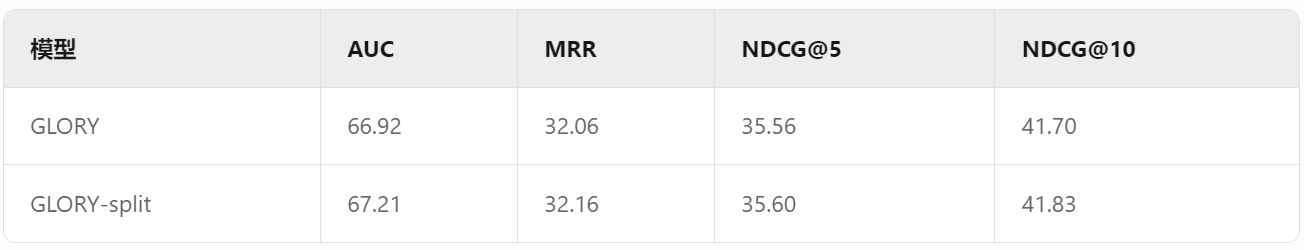

根据实验结果，GLORY-split在AUC和NDCG@5这两个关键指标上相较于GLORY有所提升。首先，AUC从66.92提升至67.21，表明拆分策略有效提高了模型区分用户点击与否的能力，增强了对用户兴趣偏好的识别。其次，NDCG@5从35.56提升至35.60，虽然提升幅度较小，但说明拆分策略在前5个推荐项的相关性上有了微弱的改善，使得推荐结果在保护用户隐私的同时，更加精准地匹配了用户的兴趣。

## 实验代码总结

1. 进行图数据的处理，构建点击全局图
2. 采用拆分学习框架，在用户本地处理敏感数据，服务器仅计算全局点击图
3. 实验证明该方法在保护隐私的同时，推荐效果仍有小幅提升。

